Suyash Tambe 
22070126117

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_sine_wave_data(samples, seq_length):
    x = np.linspace(0, 2 * np.pi, seq_length)
    sine_wave = np.sin(x)
    data = []
    for _ in range(samples):
        noise = np.random.uniform(-0.1, 0.1, size=seq_length)  
        data.append(sine_wave + noise)
    return np.array(data, dtype=np.float32)

In [3]:
seq_length = 50
num_samples = 1000
latent_dim = 16
batch_size = 32
num_epochs = 1000
learning_rate = 0.0002

In [4]:
real_data = generate_sine_wave_data(num_samples, seq_length)
real_data = torch.tensor(real_data).view(-1, seq_length, 1)

In [5]:
data_loader = torch.utils.data.DataLoader(real_data, batch_size=batch_size, shuffle=True)


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z).unsqueeze(-1)

In [7]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [8]:
# Instantiate models
generator = Generator(latent_dim, seq_length)
discriminator = Discriminator(seq_length)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [9]:

for epoch in range(num_epochs):
    for real_batch in data_loader:
        # Discriminator
        optimizer_d.zero_grad()
        
        # Real data
        real_labels = torch.ones(real_batch.size(0), 1)
        fake_labels = torch.zeros(real_batch.size(0), 1)
        real_output = discriminator(real_batch)
        loss_real = criterion(real_output, real_labels)
        
        # Fake data
        z = torch.randn(real_batch.size(0), latent_dim)
        fake_data = generator(z)
        fake_output = discriminator(fake_data.detach())
        loss_fake = criterion(fake_output, fake_labels)
        
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()
        
        # Generator
        optimizer_g.zero_grad()
        
        z = torch.randn(real_batch.size(0), latent_dim)
        fake_data = generator(z)
        fake_output = discriminator(fake_data)
        loss_g = criterion(fake_output, real_labels)
        
        loss_g.backward()
        optimizer_g.step()
    
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

Epoch [100/1000] Loss D: 1.7330, Loss G: 0.6192
Epoch [200/1000] Loss D: 1.6979, Loss G: 0.5542
Epoch [300/1000] Loss D: 1.0630, Loss G: 0.9413
Epoch [400/1000] Loss D: 1.4325, Loss G: 0.7365
Epoch [500/1000] Loss D: 1.4874, Loss G: 0.6632
Epoch [600/1000] Loss D: 1.1840, Loss G: 0.8566
Epoch [700/1000] Loss D: 1.3685, Loss G: 0.6652
Epoch [800/1000] Loss D: 1.3128, Loss G: 0.7148
Epoch [900/1000] Loss D: 1.2895, Loss G: 0.7881
Epoch [1000/1000] Loss D: 1.2823, Loss G: 0.7116


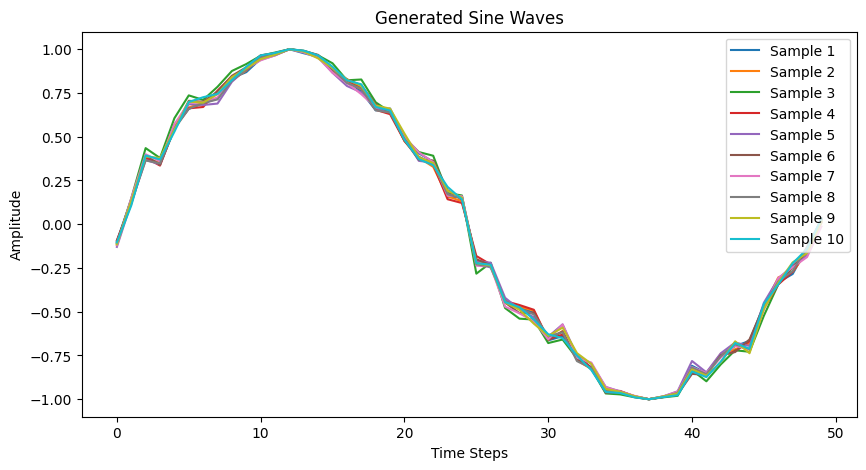

In [10]:
# Generate and plot synthetic sine waves
z = torch.randn(10, latent_dim)
synthetic_data = generator(z).detach().numpy()

plt.figure(figsize=(10, 5))
for i, sample in enumerate(synthetic_data):
    plt.plot(sample, label=f"Sample {i+1}")
plt.title("Generated Sine Waves")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()